# [通し課題]

8. DAY2、3で学んだことの取り組み • 交差検証、ホールドアウト法などで汎化性能を確認する  
 • 欠測値と異常値を確認し、適切に処理する  
 • DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する  
 • 交差検証によるパラメータチューニングを行う  
 • パラメータチューニング後のモデルによって、精度および結果の評価を行う  
 • その他、精度の向上ができるような処理に取り組み、精度を上げる  
 • できたところまでをNotebookでまとめ、宿題として提出する  
 • 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること  
 • 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます  
9. DAY4では、DAY3宿題の提出ファイルを元に、最終発表を実施いただ

# 0. DAY1~２での実施事項


In [1]:
#********************************************************************
# pandas,numpy,matplotlib,codecs,sklearnの各ライブラリをインポート
#********************************************************************

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs as cd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns

#********************************************************************
#.該当課題のデータを読み込む
#********************************************************************
#201801のデータを読み込んでみる
with cd.open('ks-projects-201801.csv', 'r', 'utf-8', 'ignore') as f18:
    df_f18 = pd.read_csv(f18)
#df_f18 = pd.read_csv('ks-projects-201801.csv')

#********************************************************************
#.欠損値がある行は、とりあえずなくしてみる
#********************************************************************
#１個でも欠損値がある行はとりあえず削除してみる。
df_f18_dna = df_f18.dropna(how='any')

#********************************************************************
#.成功（'successful'）と失敗（'failed'）に絞って考える。
#********************************************************************
#成功だけを抽出したDFと失敗だけを抽出したDF
df_f18_success = df_f18_dna[df_f18_dna['state']=='successful']
df_f18_failed =  df_f18_dna[df_f18_dna['state']=='failed']
#両方を結合
df_f18_SorF = pd.concat([df_f18_success,df_f18_failed])

#********************************************************************
#.'state'をカテゴリ変数（文字列）から数値化してみる。
#********************************************************************
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#stateに出てくるカテゴリを覚えて
#stateを数値に変換
le = le.fit(df_f18_SorF['state'])
df_f18_SorF['state'] = le.transform(df_f18_SorF['state'])

#********************************************************************
#.'deadline' 'launched' の項目から期間'days'を日数で割り出す
#********************************************************************
# 'deadline' 'launched' の項目をdatetimeに変更
df_f18_SorF['deadline'] = pd.to_datetime(df_f18_SorF['deadline'], errors = 'coerce')
df_f18_SorF['launched'] = pd.to_datetime(df_f18_SorF['launched'], errors = 'coerce')
# 'deadline' 'launched' の間の日数を示す'period'を作成
df_f18_SorF['period'] = df_f18_SorF['deadline'] - df_f18_SorF['launched']

days = []

#'period'の日数を'days'に抽出
for i in df_f18_SorF.index:
    days.append(df_f18_SorF['period'][i].days)
#'days'列を追加
df_f18_SorF['days'] = days

#####################################
#異常値を除いたデータフレームを作る。
#####################################
#goalの異常値を除いたデータフレーム
df_train = df_f18_SorF[df_f18_SorF['goal']<99999999]

#####################################
#country,main_category,categoryをOne-Hotに変換する。
#####################################
df_train = pd.get_dummies(df_train, columns=['country', 'category', 'main_category'])


In [2]:
train_label = df_train['state']
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)


In [3]:
# 標準化
train_data = (train_data - train_data.mean()) / train_data.std()
train_data = train_data.astype('float32')

# １．交差検証、ホールドアウト法などで汎化性能を確認する  

## 1.1. 欠測値と異常値を確認し、適切に処理する 

##  1.2. DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する

### 1.3. 交差検証によるパラメータチューニングを行う

In [4]:
# ホールドアウト法に関する関数
from sklearn.model_selection import train_test_split
# 交差検証法に関する関数
from sklearn.model_selection import KFold
# 回帰問題における性能評価に関する関数
from sklearn.metrics import mean_absolute_error

ホールドアウト法で、最終的に性能を見るためのテストデータを別にする。（３０％をテストデータに）  

In [3]:
#train_label = df_train['state']
#train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)

#目的変数'state'を正解としてyに格納
y = train_label.values
#説明変数'goal','backers','days','country_rate','main_category_rate','category_rate'を入力としてXに格納
X = train_data.values
#X = df_train[['goal', 'backers','days','country_rate','main_category_rate','category_rate']].values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(144879, 199) (62091, 199) (144879,) (62091,)


# 1.5. その他、精度の向上ができるような処理に取り組み、精度を上げる

## AdaBoostでも試してみる。

### Lassoの特徴量削減は行わず、改めて３割をテストデータ、７割を訓練データに分割する。

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#　ラベルデータとして’state’を作成
#adB_train_label = df_train['state']
adB_train_label = train_label

#　Leakageになりそうなカラム、相関が強いカラムをドロップする
#adB_train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)
adB_train_data = train_data

#目的変数'state'を正解としてyに格納
adB_y = adB_train_label.values
#カラムをドロップした説明変数を、Xに格納
adB_X = adB_train_data.values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
adB_X_train, adB_X_test, adB_y_train, adB_y_test = train_test_split(adB_X, adB_y, test_size=test_size,shuffle=True, random_state=1234) 

print(adB_X_train.shape, adB_X_test.shape, adB_y_train.shape, adB_y_test.shape)

C:\Users\junka\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(144879, 199) (62091, 199) (144879,) (62091,)


### max_depthを変化させて、Accuracyが最大になる値を探す。
### 探すにあたっては、交差検証法を利用する。  

In [9]:
#毎のAccuracy格納用データフレームを初期化
df_md_Acc = pd.DataFrame(index=[], columns=['max_depth','val_acc'])
for max_depth in np.arange(1,10,1):
    #クロスバリデーションの検証毎のAccuracy格納用データフレームを初期化
    df_val_Acc = pd.DataFrame(index=[], columns=['val_acc'])
    #クロスバリデーションでの検証ステップを初期化
    #クロスバリデーションで検証
    for train_index, test_index in KFold(n_splits=2,shuffle=True, random_state=1234).split(adB_X_train, adB_y_train):
        adB_X_val_train, adB_X_val_test = adB_X[train_index], adB_X[test_index]
        adB_y_val_train, adB_y_val_test = adB_y[train_index], adB_y[test_index]
        #print(adB_X_val_train.shape, adB_X_val_test.shape,adB_y_val_train.shape, adB_y_val_test.shape)

        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,min_samples_split=2,random_state=1234,criterion="gini"),
                                           n_estimators=10, random_state=1234)
        clf.fit(adB_X_val_train, adB_y_val_train)
        score = clf.score(adB_X_val_test, adB_y_val_test)
        print("max_depth=",max_depth)
        print("score=", score)
        
        val_se = pd.Series( [score], index=df_val_Acc.columns )
        
        df_val_Acc = df_val_Acc.append(val_se, ignore_index = True,sort=False) 
 
    md_df = pd.DataFrame(index=[],columns=['max_depth','val_acc'])
    md_df = md_df.append(df_val_Acc.mean(),ignore_index = True,sort=False)
    md_df['max_depth'] = max_depth
    
    df_md_Acc = df_md_Acc.append(md_df, ignore_index = True,sort=False)

max_depth= 1
score= 0.7250552181115406
max_depth= 1
score= 0.7215174146523282
max_depth= 2
score= 0.7578685808945335
max_depth= 2
score= 0.7585968884164608
max_depth= 3
score= 0.7639425731639978
max_depth= 3
score= 0.7657615372934469
max_depth= 4
score= 0.7642186637217007
max_depth= 4
score= 0.7667968911774045
max_depth= 5
score= 0.7650331308669244
max_depth= 5
score= 0.7665346015268019
max_depth= 6
score= 0.7629624516841524
max_depth= 6
score= 0.7646157456618672
max_depth= 7
score= 0.7641358365543899
max_depth= 7
score= 0.7631800549427794
max_depth= 8
score= 0.7614715626725566
max_depth= 8
score= 0.7623241623987079
max_depth= 9
score= 0.7598840419657648
max_depth= 9
score= 0.7588867875039689


,max_depth,val_acc
0,1,0.723286
1,2,0.758233
2,3,0.764852
3,4,0.765508
4,5,0.765784
5,6,0.763789
6,7,0.763658
7,8,0.761898
8,9,0.759385


max_depth    9.000000
val_acc      0.765784
dtype: float64

,val_acc
0,0.759884
1,0.758887


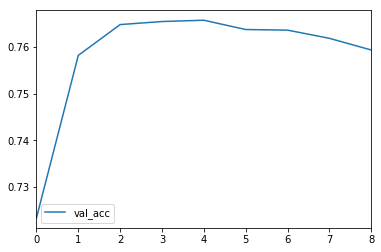

In [11]:
display(df_md_Acc)
display(df_md_Acc.max())
display(df_val_Acc)
df_md_Acc[['val_acc']].plot()
plt.show()

#### max_depthが4のときにバリデーションでのAccuracyが約76.5%の最大値が出ているので、採用
#### 訓練データをすべて投入し、テストデータでの精度を確認する。

In [12]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,min_samples_split=2,random_state=1234,criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(adB_X_train, adB_y_train)
print("score=", clf.score(adB_X_test, adB_y_test))


score= 0.6750253659950718


### クロスバリデーション時よりは精度が下がったが、NNよりも精度があがった。

### 予測時に使われている説明変数を確認する。

[0.00942993 0.20151957 0.1678284  0.         0.         0.
 0.         0.         0.         0.         0.         0.00043845
 0.00908233 0.         0.         0.01692348 0.         0.
 0.00055108 0.         0.         0.         0.00055197 0.
 0.02077308 0.         0.         0.         0.         0.
 0.         0.00054818 0.         0.02186462 0.         0.
 0.01449446 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01564556 0.         0.         0.         0.         0.
 0.         0.01574113 0.         0.         0.         0.
 0.         0.         0.         0.         0.01390716 0.
 0.         0.01961432 0.         0.00042681 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02072921 0.         0.         0.         0.
 0.02046626 0.00323692 0.         0.         0.         0.
 0.         0.         0.         0.02223817 0.         0.01080614
 0.         0.01313222 0.         0.    

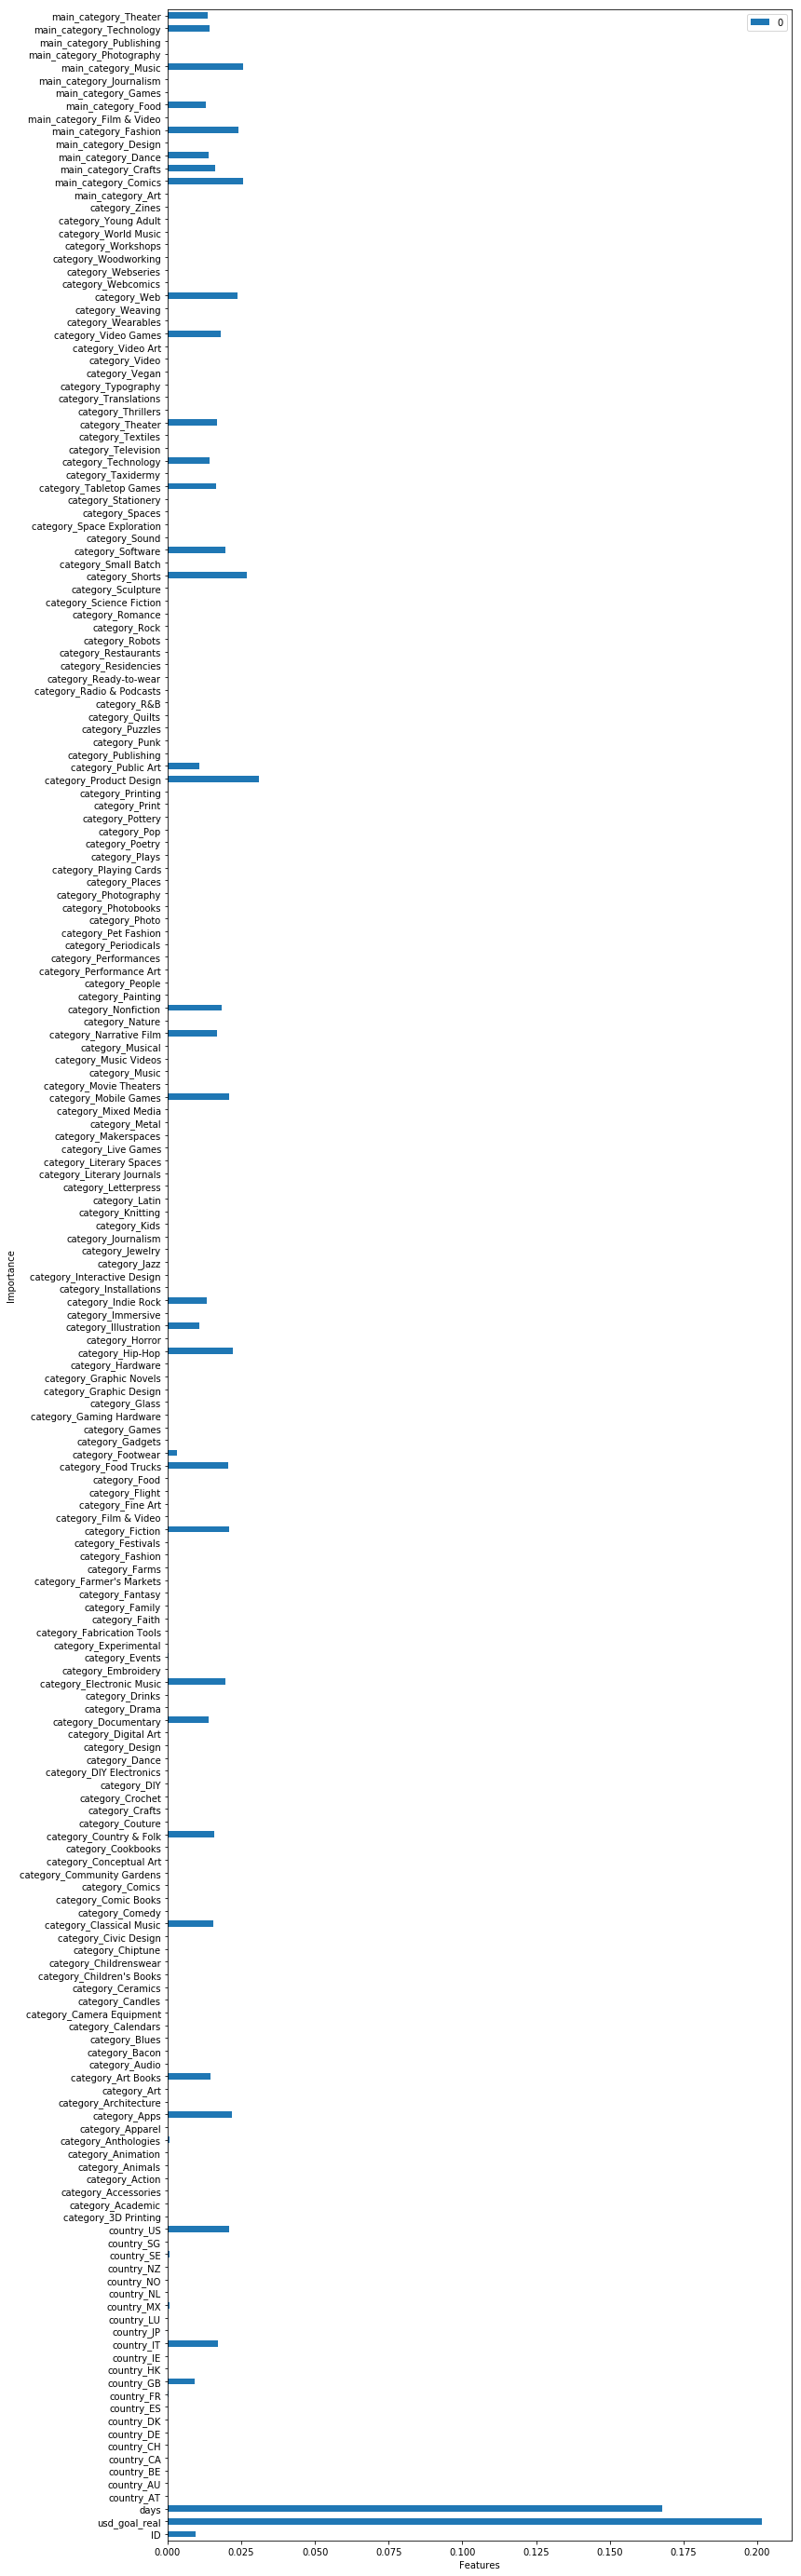

In [50]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=adB_train_data.columns).plot.barh(figsize=(12,50))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### LassoCVに比べて、特徴量が大幅に削減されている。計算量の観点で、次元が大幅に削減できているので、今回のデータセットではAdaBoostは効率的であった。

### 1.6. できたところまでをNotebookでまとめ、宿題として提出する  

### 1.7. 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること 

### 1.8. 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます